In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import os
import numpy as np
import sklearn.cross_validation as xval
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde

DATAPATH = '../data'
dataset = pd.read_csv(os.path.join(DATAPATH, "autosomal_perlocus_train_intergenic.bed.gz"), sep="\t").drop_duplicates()
dataset['period'] = dataset['motif'].str.len()
features = ['uninterrupted_length', 'length','period','recomb','gc','entropy','reptiming']

# Filter to things with length >= 25, period is di, tri, or tetra
dataset = dataset[(dataset["length"] >= 20) & (dataset["period"].apply(lambda x: x in [2,3,4]))]
dataset = dataset[~dataset["featurefilter"]]
dataset = dataset[dataset['ml_mu'] > -7] # Remove things at the optimization boundaries for mu
dataset = dataset[dataset['ml_beta'] < 0.899][dataset["ml_beta"] > 0.001] # Remove things at the optimization boundaries 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [2]:
print len(dataset)
dataset.head()

9590


,chrom,start,end,ml_mu,ml_beta,ml_p,ml_mu_stderr,numsamples,strfilter,motif,length,uninterrupted_length,recomb,gc,entropy,reptiming,featurefilter,period
172,1,8161208,8161242,-3.533541,0.063897,0.733707,0.240124,299,PASS,AAT,35,35,0.321681,0.44,1.950227,0.823000,False,3
268,1,8247414,8247440,-5.610080,0.818441,0.700001,1.275348,299,PASS,AAAT,27,27,0.000000,0.46,1.975354,0.928508,False,4
274,1,8248832,8248859,-4.331834,0.104025,1.000000,0.302200,297,PASS,AAAT,28,28,0.000000,0.43,1.980472,0.929933,False,4
278,1,8250735,8250761,-6.058039,0.319434,0.999998,2.290364,283,PASS,AAAT,27,23,0.000000,0.37,1.899003,0.931402,False,4
282,1,8251241,8251265,-5.765409,0.855256,0.999998,1.575337,295,PASS,AAAT,25,25,0.000000,0.41,1.971969,0.933077,False,4


# Visualize **kernel density estimation**

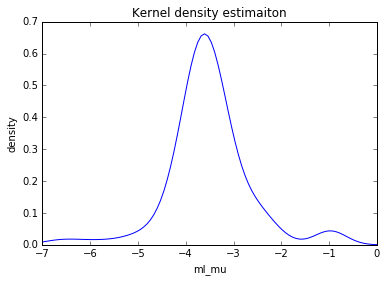

Get the max density around: -3.60606060606


In [3]:
test = dataset[(dataset['uninterrupted_length'] == 30) & (dataset['period'] == 2)]
test_density = gaussian_kde(test['ml_mu'])
test_xs = np.linspace(-7,0,100)
plt.plot(test_xs, test_density(test_xs))
plt.xlabel('ml_mu')
plt.ylabel('density')
plt.title('Kernel density estimaiton')
plt.show()
print 'Get the max density around: %s' %test_xs[np.argmax(test_density(test_xs))]

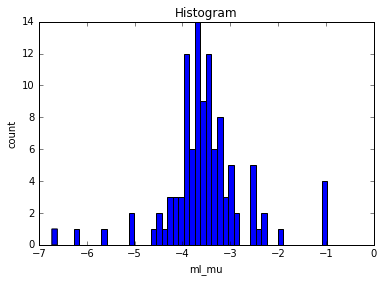

In [4]:
plt.hist(test['ml_mu'], 50)
plt.xlabel('ml_mu')
plt.ylabel('count')
plt.title('Histogram')

# Reserve the data around the density peak, and drop others

In [5]:
p_l_dict = {}
for idx, row in dataset.iterrows():
    if row['period'] not in p_l_dict:
        p_l_dict[row['period']] = []
    else:
        if row['uninterrupted_length'] not in p_l_dict[row['period']]:
            p_l_dict[row['period']].append(row['uninterrupted_length'])
            

clean_data = pd.DataFrame()
xs = np.linspace(-7,0,100)
for p in p_l_dict:
    for l in p_l_dict[p]:
        tmp = dataset[(dataset['uninterrupted_length'] == l) & (dataset['period'] == p)]
        if len(tmp) < 2:
            continue
        density = gaussian_kde(tmp['ml_mu'])
        peak = xs[np.argmax(density(xs))]
        fil = dataset[(dataset['uninterrupted_length'] == l) & (dataset['period'] == p) 
                      & (dataset['ml_mu'] > peak - 0.5) & (dataset['ml_mu'] < peak + 0.5)]
        clean_data = pd.concat([clean_data, fil])

In [6]:
len(clean_data)

5639

# Split train and test data

In [7]:
# for cleaned data
clean_X = clean_data[features]
clean_y = clean_data['ml_mu']
clean_train_X, clean_test_X, clean_train_y, clean_test_y = xval.train_test_split(clean_X, clean_y, test_size=0.25)

# for uncleaned data
unclean_X = dataset[features]
unclean_y = dataset['ml_mu']
unclean_train_X, unclean_test_X, unclean_train_y, unclean_test_y = xval.train_test_split(unclean_X, unclean_y, test_size=0.25)

# Random forest

In [8]:
# train the RF model in cleaned data

rf = RandomForestRegressor()
rf.fit(clean_train_X, clean_train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

**test on cleaned data**

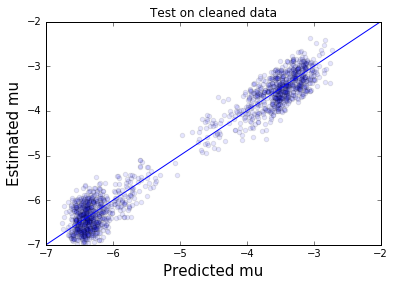

0.959842345049
(0.97978581312891089, 0.0)


In [9]:
clean_pred_y = rf.predict(clean_test_X)
plt.scatter(clean_pred_y, clean_test_y, alpha=0.1)
plt.plot([-7, -2],[-7,-2])
plt.xlim(-7, -2)
plt.ylim(-7, -2)
plt.xlabel("Predicted mu", size=15)
plt.ylabel("Estimated mu", size=15)
plt.title('Test on cleaned data')
plt.show()
print rf.score(clean_test_X, clean_test_y)
print pearsonr(clean_test_y, clean_pred_y)

**use RF trained on cleaned data to test on uncleaned data**

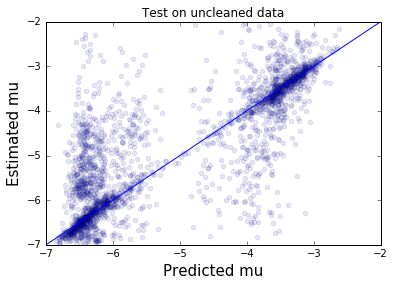

0.523305664114
(0.76999827553334255, 0.0)


In [10]:
unclean_pred_y = rf.predict(unclean_test_X)
plt.scatter(unclean_pred_y, unclean_test_y, alpha=0.1)
plt.plot([-7, -2],[-7,-2])
plt.xlim(-7, -2)
plt.ylim(-7, -2)
plt.xlabel("Predicted mu", size=15)
plt.ylabel("Estimated mu", size=15)
plt.title('Test on uncleaned data')
plt.show()
print rf.score(unclean_test_X, unclean_test_y)
print pearsonr(unclean_test_y, unclean_pred_y)

**compare**

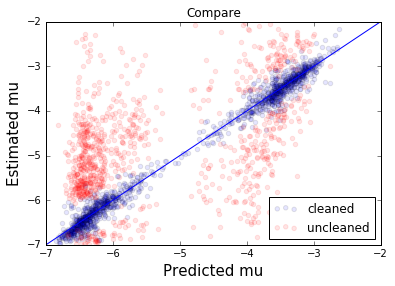

In [11]:
unclean_test = unclean_test_X.join(unclean_test_y)
intersect = clean_data.merge(unclean_test)# data in unclean_test which are also included in cleand train set 
other = unclean_test[~unclean_test.index.isin(clean_data.index)]

plt.scatter(rf.predict(intersect[features]), intersect['ml_mu'], alpha=0.1, label='cleaned')
plt.scatter(rf.predict(other[features]), other['ml_mu'], color='red', alpha=0.1, label='uncleaned')
plt.plot([-7, -2],[-7,-2])
plt.xlim(-7, -2)
plt.ylim(-7, -2)
plt.xlabel("Predicted mu", size=15)
plt.ylabel("Estimated mu", size=15)
plt.legend(loc='lower right')
plt.title('Compare')
plt.show()